# Bayesian-free Gaussian processes

Collection of datasets taken from https://www.sfu.ca/~ssurjano/optimization.html

In [1]:
import jax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 4.0)

sns.set_palette("colorblind")

jax.config.update("jax_enable_x64", True)

%config InlineBackend.figure_format = "retina"

## The noisless case

Let $Y: {\cal X} \to \mathbb{R}$ be a random variable
such that, for any $x_i, x_j \in {\cal X}$,
$$
\begin{aligned}
    \mathbb{E}[Y(x_i)] &= 0\\
    {\rm Cov}(Y(x_i),Y(x_j)) = \mathbb{E}[Y(x_i)\,Y(x_j)] &= k(x_i\,x_j)
\end{aligned}
$$

where $k:\mathbb{R}^m\times\mathbb{R}^m\to\mathbb{R}$ is a valid *kernel function*.

## Problem statement
Suppose we are given members of the sample space 
and $\{x_1, \ldots, x_t, x_{t+1}, x_{t+j}\} \subseteq {\cal X} \subseteq {\mathbb R}^m$.
Our goal is to find the best linear unbiased predictor (BLUP) for the random variables $Y_{t+1:t+j}$
given the subset of measurements $Y_{1:t}$.

That is, we seek a matrix ${\bf A}^* \in {\mathbb R}^{j\times t}$ such that
$$
    {\bf A}^* = \arg\min_{{\bf A}}\mathbb{E}[\|Y_{t+1:t+j} - {\bf A}\,Y_{1:t}\|^2_2]
$$

This takes the form

$$
    {\bf A}^* = {\rm Cov}(Y_{t+1,t+j},Y_{1:T})\,{\rm Var}(Y_{1:t})^{-1}
$$

As a consequence, the best linear unbiased predictor and the error variance-covariance matrix take the form
$$
\begin{aligned}
    \hat{Y}_{t+1:t+j} = {\bf A}^*\,Y_{1:t}
    &= {\rm Cov}(Y_{t+1,t+j},Y_{1:T})\,{\rm Var}(Y_{1:t})^{-1}\,Y_{1:T}\\
    {\rm Var}(Y_{t+1:t+j} - \hat{Y}_{t+1:t+j}) &= {\rm Var}(Y_{t+1:t+j}) - {\bf A}^*\,{\rm Var}(Y_{1:t})\,{\bf A}^{*\intercal}
\end{aligned}
$$

Because we assume knowledge of the covariance between any two elements of the sample space ${\cal X}$,
it follows that the GP prediction is completely determined by its kernel function $k$ and sampled values for $Y_{1:t}$

In [3]:
def sample_multivariate_gauss(key, mean, cov, n_samples, min=1e-7):
    dim = cov.shape[0]
    cov = (cov + cov.T) / 2
    ev = jnp.linalg.eigh(cov)
    cov = ev.eigenvectors @ jnp.diag(jnp.clip(ev.eigenvalues, min=1e-7)) @ jnp.linalg.inv(ev.eigenvectors)
    L = jnp.linalg.cholesky(cov)
    rvs = jax.random.normal(key, shape=(dim, n_samples))
    return (L @ rvs) + mean[:, None]

### Example: a Gasussian kernel

In [30]:
def kgauss(u, v, sigma2=1.0):
    return jnp.exp(-(u[:, None] - v[None, :]) ** 2 / (2 * sigma2))

Text(0.5, 0, 'Sample space ${\\cal X}$')

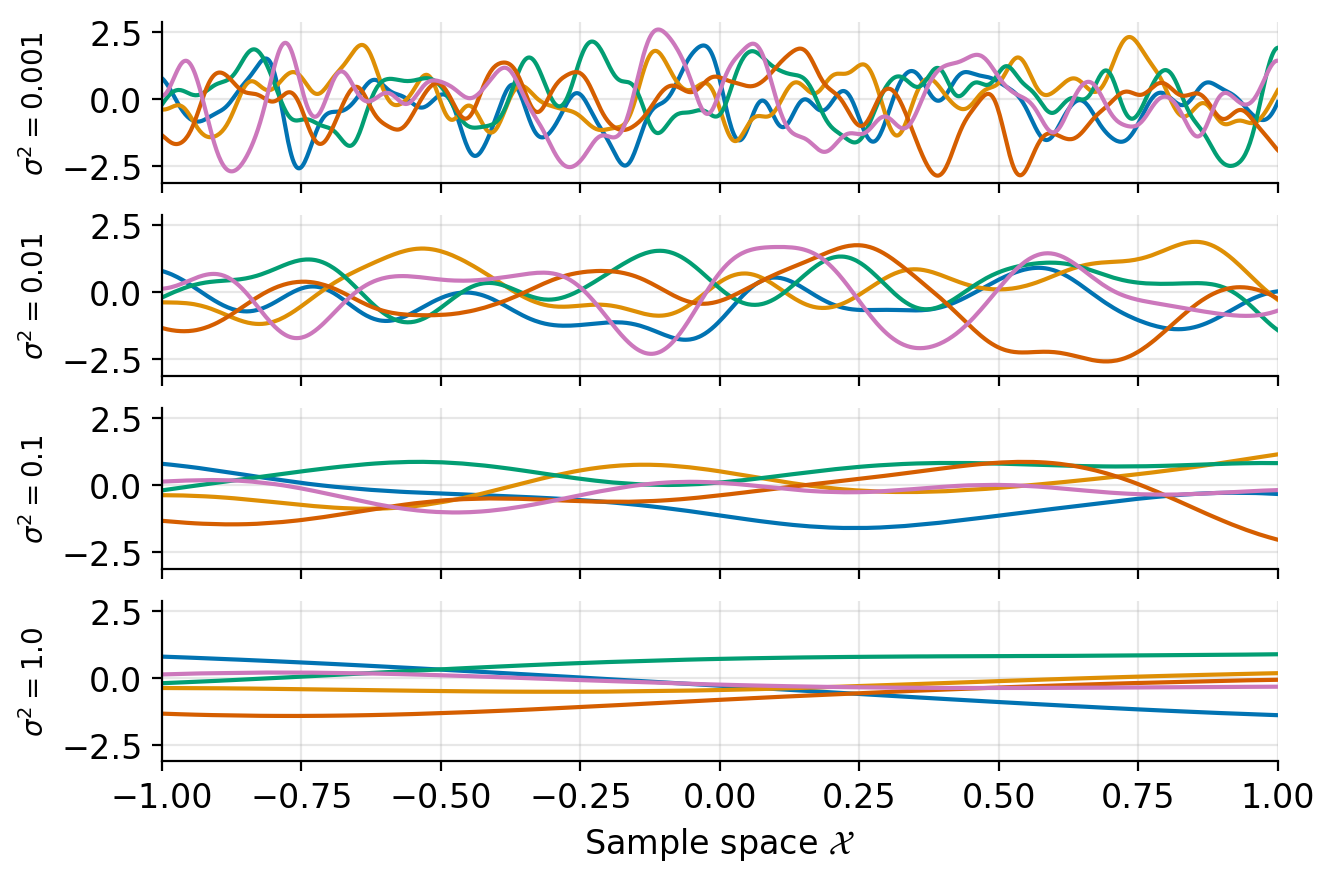

In [179]:
key = jax.random.PRNGKey(314)
key_x, key_sample = jax.random.split(key)

n = 1000
x = jax.random.uniform(key=key_x, minval=-1, maxval=1, shape=(n,)).sort()[:, None]
x = jnp.linspace(-1, 1, n)


fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(7.2, 4.0 * 1.2))
n_samples = 5

sigma2 = 1.0
reg = 1e-7
mean = jnp.zeros(n)

sigma2_vals = jnp.array([0.001, 0.01, 0.1, 1.0])
for ax, sigma2 in zip(axs, sigma2_vals):
    cov = kgauss(x, x, sigma2)
    sample = sample_multivariate_gauss(key_sample, mean, cov, n_samples)
    ax.plot(x, sample)
    ax.set_ylabel(rf"$\sigma^2={sigma2}$", fontsize=10)
    ax.set_xlim(-1, 1)
    ax.grid(alpha=0.3)
ax.set_xlabel(r"Sample space ${\cal X}$")

## BLUP (posterior predictive) estimation

In [211]:
def kgauss(u, v, sigma2=1.0):
    return jnp.exp(-(u[:, None] - v[None, :]) ** 2 / (2 * sigma2))

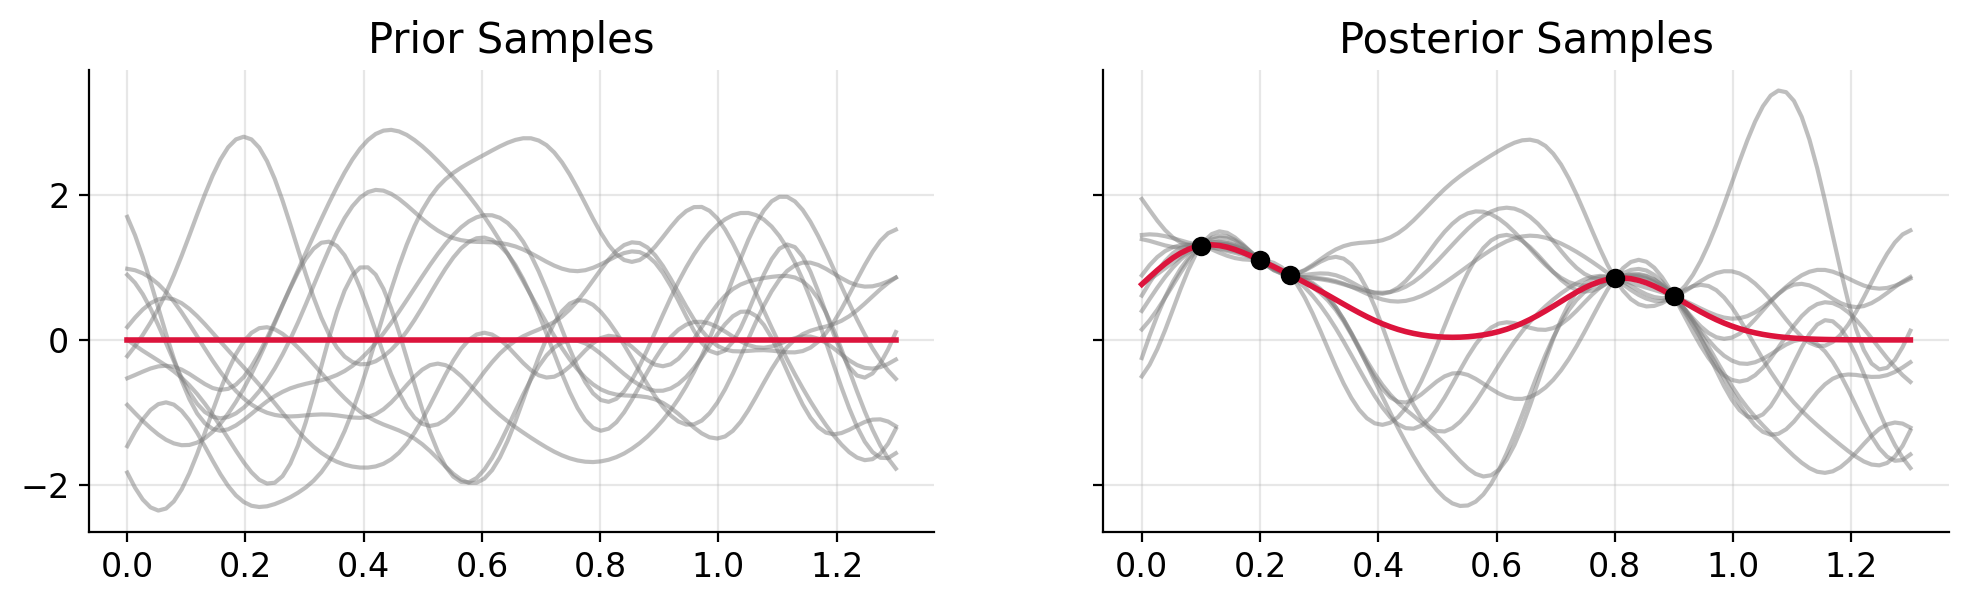

In [212]:
xtest = jnp.linspace(0, 1.3, 100)
mu_prior = jnp.zeros_like(xtest)
sigma = 0.01
n_samples = 10
x = jnp.array([0.1, 0.2, 0.25, 0.8, 0.9])
y = jnp.array([1.3, 1.1, 0.9, 0.85, 0.6])

var_train = kgauss(x, x, sigma)
cov_test_train = kgauss(xtest, x, sigma)
var_test = kgauss(xtest, xtest, sigma)

A_blup = jnp.linalg.solve(var_train, cov_test_train.T).T
mu_post = A_blup @ y
sigma_post = var_test - A_blup @ var_train @ A_blup.T

posterior_sample = sample_multivariate_gauss(key, mu_post, sigma_post, n_samples=n_samples)
prior_sample = sample_multivariate_gauss(key, mu_prior, var_test, n_samples=n_samples)

fig, ax = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

ax[0].plot(xtest, prior_sample, alpha=0.5, c="tab:gray");
ax[0].set_title("Prior Samples", fontsize=15)
ax[0].plot(xtest, mu_prior, c="crimson", linewidth=2)

ax[1].plot(xtest, posterior_sample, alpha=0.5, c="tab:gray");
ax[1].plot(xtest, mu_post, c="crimson", linewidth=2)
ax[1].scatter(x, y, marker="o", c="black", zorder=5)
ax[1].set_title("Posterior Samples", fontsize=15)
for axi in ax:
    axi.grid(alpha=0.3)

Text(0, 0.5, 'Observation space $Y(X_j)$')

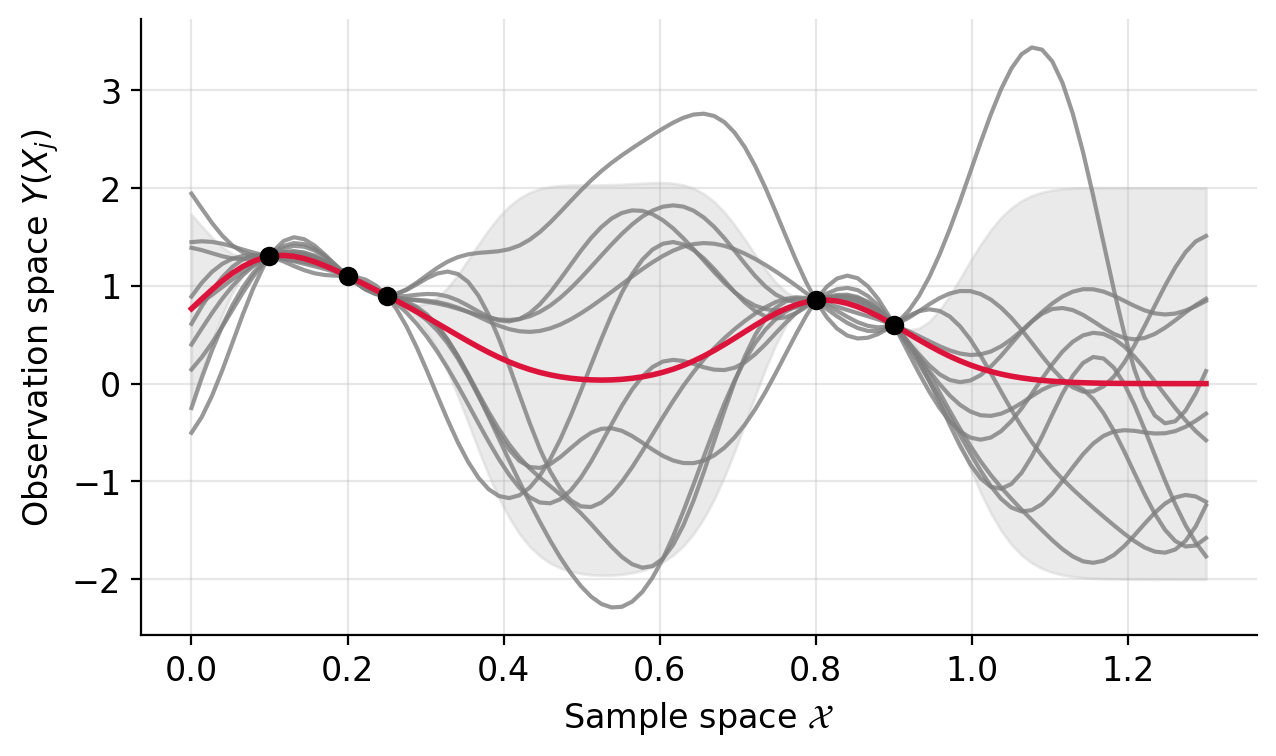

In [213]:
upper_bound = mu_post.ravel() + 2 * jnp.diag(sigma_post)
lower_bound = mu_post.ravel() - 2 * jnp.diag(sigma_post)

plt.plot(xtest, posterior_sample, alpha=0.8, c="tab:gray");
plt.plot(xtest, mu_post, c="crimson", linewidth=2)
plt.scatter(x, y, marker="o", c="black", zorder=5)
plt.fill_between(xtest, lower_bound, upper_bound, color="#ccc6")
plt.grid(alpha=0.3)
plt.xlabel(r"Sample space ${\cal X}$")
plt.ylabel(r"Observation space $Y(X_j)$")

## Sequential update

In [216]:
n = 15
noise = 0.0

def f(x): return jnp.sin(4 * x) + jnp.cos(2 * x)
xtest = jnp.linspace(-4, 4, 500)
ytest = f(xtest)

key = jax.random.PRNGKey(314)
x = jax.random.uniform(key=key, minval=-4.0, maxval=4.0, shape=(n,))
y = f(x)

Text(0.5, 0.92, 'GP iterpolation')

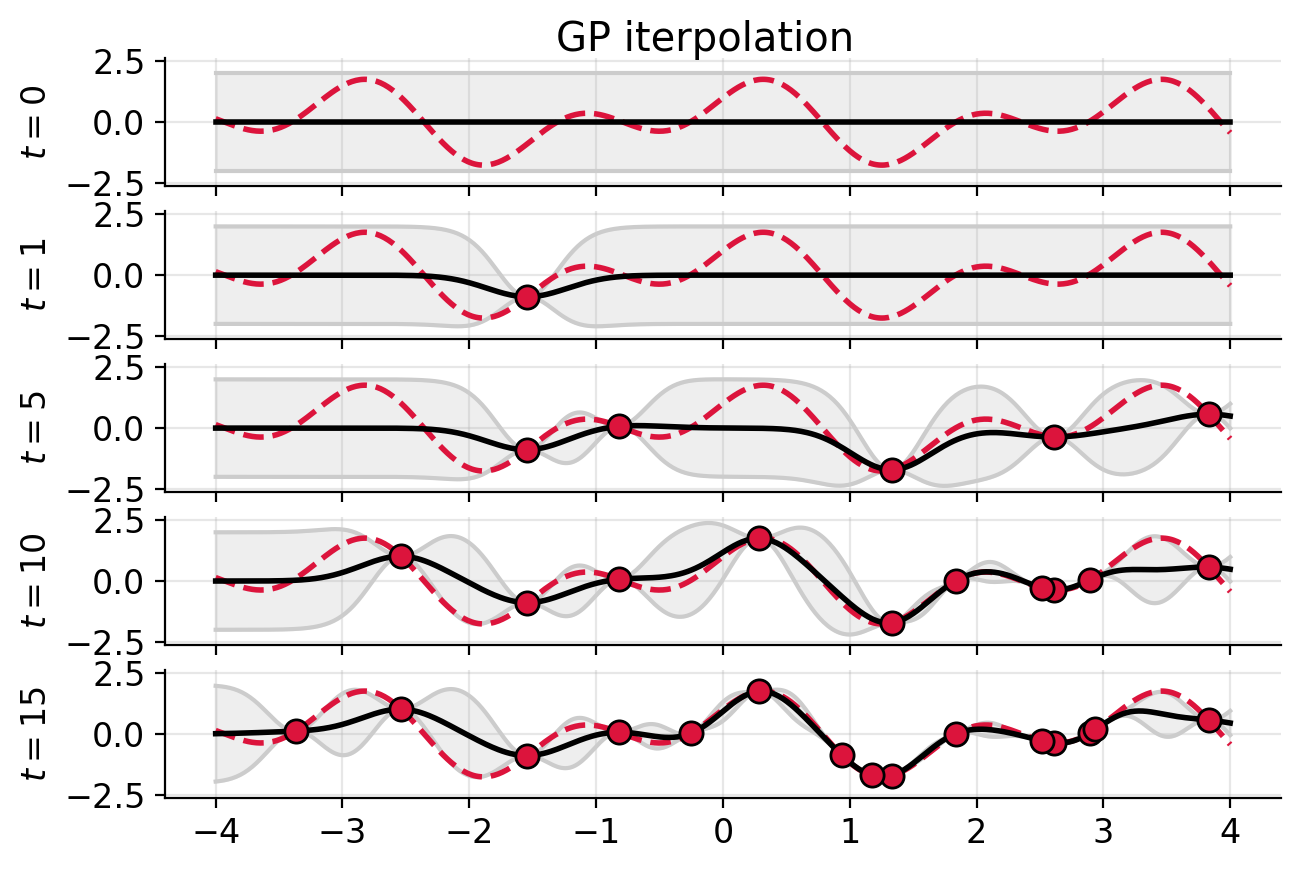

In [248]:
sigma = 0.1

n_obs_values = [0, 1, 5, 10, 15]
fig, axs = plt.subplots(len(n_obs_values), 1, sharex=True, sharey=True, figsize=(7.2, 4.0 * 1.2))
for ax, n_obs in zip(axs, n_obs_values):
    var_train = kgauss(x[:n_obs], x[:n_obs], sigma)
    cov_test_train = kgauss(xtest, x[:n_obs], sigma)
    var_test = kgauss(xtest, xtest, sigma)
    
    A_blup = jnp.linalg.solve(var_train, cov_test_train.T).T
    mu_post = A_blup @ y[:n_obs]
    sigma_post = var_test - A_blup @ var_train @ A_blup.T

    upper_bound = mu_post.ravel() + 2 * jnp.diag(sigma_post)
    lower_bound = mu_post.ravel() - 2 * jnp.diag(sigma_post)
    ax.fill_between(xtest, lower_bound, upper_bound, color="#ccc5")
    ax.plot(xtest, lower_bound, c="#ccc", linewidth=1.5)
    ax.plot(xtest, upper_bound, c="#ccc", linewidth=1.5)
    
    ax.plot(xtest, ytest, label="latent function", c="crimson", linewidth=2, linestyle="--")
    ax.plot(xtest, mu_post, c="black", linewidth=2, label="estimated function")
    ax.scatter(x[:n_obs], y[:n_obs], marker="o", edgecolor="black", zorder=5, label="observations", s=70, c="crimson")
    ax.grid(alpha=0.3)
    ax.set_ylabel(f"$t={n_obs}$")
plt.suptitle("GP iterpolation", y=0.92)
# plt.legend(loc="lower left", fontsize=10))